# Import Module

In [ ]:
import csv
import time
import sys
import os
import random

# other library
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from tqdm.notebook import tqdm 

# Fix random seed

In [ ]:
SEED = 5566 # Do not modify
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Dataset Download:

In [ ]:
!gdown --id "1Ei-z7wuOosboqxlJj0V99XXyhNlc-eDs" --output "trainX.npy"
!gdown --id "11DCdXZkJqMgMZaPhgwU8WCJ_HCRW5LBw" --output "visualization_X.npy"


# Set Hyper-parameters

In [ ]:
NUM_EPOCH = 500
BATCH_SIZE = 64
LATENT_DIM = 32
REDUCED_DIM = 8 
NUM_ITER = 1000
REDUCED_METHOD = 'tsne'
lr = 5e-4

In [ ]:
MODEL_NAME = 'model.pth'
DATA_PATH = 'trainX.npy'

# Define Dataset

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, data_path):
        self.total_img = torch.from_numpy(np.load(data_path)).float()
        self.total_img = self.total_img.permute(0, 3, 1, 2)
        self.total_img = self.total_img/255

    def normalize(self, img):
        mean, std = img.mean([0,1,2]), img.std([0,1,2])
        normal = transforms.Compose([
          transforms.Normalize(mean, std),
          ])
        return normal(img)
        
    def augment(self, img):
        transform = transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(p=0.4)
            ])
        img = transform(img)
        return img
    
    def __len__(self):
        return len(self.total_img)

    def __getitem__(self, index):
        img = self.total_img[index]
        img_aug = self.augment(img)

        img_aug = self.normalize(img_aug)
        img = self.normalize(img)
        
        return img_aug, img

# Define Model Architerchure

reference:
  1. Yifei, Z. A Better Autoencoder for Image: Convolutional Autoencoder.
  2. Santiago, L, V. Convolutional autoencoder for image denoising.


In [ ]:
class TestNet(nn.Module):
    def __init__(self, image_channels=3, latent_dim=LATENT_DIM):
        super(TestNet, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=3, stride=1, padding=1), # (32+2-2-1)/1 + 1 =32
            nn.MaxPool2d(2,2,0), # 16
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 16
            nn.MaxPool2d(2,2,0), # 8
            nn.ReLU(True),
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(2048, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, 2048)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 8, 8))

        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0), # 7*2+1+1=16
           nn.ReLU(True),
           nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0), # 32
           nn.ReLU(True),
           nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1), # 32
        )
                
    def forward(self, x):
      
        feature_map = self.flatten(self.encoder(x))
        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        feature_map2 = self.unflatten(self.fc2(latent_vec))
        x_res = self.decoder(feature_map2)
        
        return latent_vec, x_res

In [ ]:
class Avgnet(nn.Module):
    def __init__(self, image_channels=3, latent_dim=LATENT_DIM):
        super(Avgnet, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=1, padding=1), # (32+2-2-1)/1 + 1 = 32
            nn.AvgPool2d(2,1,1), # (32-1+2-1)/1 +1 = 33 
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 33
            nn.AvgPool2d(2,1,1), # 34
            nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # 34
            nn.AvgPool2d(2,1,1), # 35
            nn.ReLU(True),
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(19600, self.latent_dim)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(2, 4, 4))

        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(2, 16, kernel_size=5, stride=2, padding=1), # (4-1)*2+1-2+4= 9
           nn.ReLU(True),
           nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1), # 17
           nn.ReLU(True),
           nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, padding=1), # 32
           nn.ReLU(True),
           nn.ConvTranspose2d(8, 3, kernel_size=3, stride=1, padding=1), # 32
        )
                
    def forward(self, x):
      
        feature_map = self.flatten(self.encoder(x))
        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        feature_map2 = self.unflatten(latent_vec)
        x_res = self.decoder(feature_map2)
        
        return latent_vec, x_res

In [ ]:
class Maxnet(nn.Module):
    def __init__(self, image_channels=3, latent_dim=LATENT_DIM):
        super(Maxnet, self).__init__()
        self.latent_dim = latent_dim
        self.img_size = 32
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=3, stride=1, padding=1), # (32+2-2-1)/1 + 1 = 32
            nn.MaxPool2d(2,1,1), # 33
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 33
            nn.MaxPool2d(2,1,1), # 34
            nn.ReLU(True),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # 34
            nn.MaxPool2d(2,1,1), # 35
            nn.ReLU(True),
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(19600, self.latent_dim)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(2, 4, 4))

        self.decoder = nn.Sequential(
           nn.ConvTranspose2d(2, 16, kernel_size=5, stride=2, padding=1), # (4-1)*2+1-2+4= 9
           nn.ReLU(True),
           nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1), # 17
           nn.ReLU(True),
           nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2, padding=1), # 32
           nn.ReLU(True),
           nn.ConvTranspose2d(8, 3, kernel_size=3, stride=1, padding=1), # 32
        )
                
    def forward(self, x):
      
        feature_map = self.flatten(self.encoder(x))
        latent_vec = self.fc1(feature_map.reshape(feature_map.shape[0], -1))
        feature_map2 = self.unflatten(latent_vec)
        x_res = self.decoder(feature_map2)
        
        return latent_vec, x_res

# Define Training Process

In [ ]:
def training(train, val, model, device, n_epoch, batch, save_name, lr):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('=== start training, parameter total:%d, trainable:%d' % (total, trainable))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                             weight_decay=1e-5)
    best_loss = 100
    for epoch in range(n_epoch):
        total_loss = 0
        
        # training set
        model.train()
        idx = 0
        for image_aug, image in tqdm(train):
            image = image.to(device, dtype=torch.float)
            image_aug = image_aug.to(device, dtype=torch.float)
            _, reconsturct = model(image_aug)
            loss = criterion(reconsturct, image)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += (loss.item() / len(train))

            print('[Epoch %d | %d/%d] loss: %.4f' %
                 ((epoch+1), idx*batch, len(train)*batch, loss.item()), end='\r')
            idx += 1 
        print("\n  Training  | Loss:%.4f " % total_loss)

        # validation set
        model.eval()
        total_loss = 0
        idx = 0 
        with torch.no_grad():
            for image_aug, image in tqdm(val):
                image = image.to(device, dtype=torch.float)
                image_aug = image_aug.to(device, dtype=torch.float)
                _, reconstruct = model(image_aug)

                loss = criterion(reconstruct, image)
                total_loss += (loss.item() / len(val))
                idx += 1
            print(" Validation | Loss:%.4f " % total_loss)
        # save model
        if total_loss < best_loss:
                best_loss = total_loss
                print("saving model with loss %.4f...\n" % total_loss)
                torch.save(model.state_dict(), "%s" % save_name)

# Define Clustering Process

In [ ]:
def clustering(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]
    
    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()
    
    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)
    print("Start kmeans!")
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=n_iter).fit(latent_vec)
    return kmeans.labels_

# Define write function

In [ ]:
def write_output(predict_result, file_name='predict.csv'):      
    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'label'])
        for i in range(len(predict_result)):
            writer.writerow([str(i), str(predict_result[i])])

# Main Process

In [ ]:
# build dataset
dataset = Dataset(DATA_PATH)
print(len(dataset))

# Random split
train_set_size = int(len(dataset) * 0.85)
valid_set_size = len(dataset) - train_set_size
train_set, valid_set = data.random_split(dataset, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(5566))

# set data loader
train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

model1 = Avgnet(latent_dim=LATENT_DIM).to(device)
model2 = Maxnet(latent_dim=LATENT_DIM).to(device)
print(model1, model2)

training(train_loader, valid_loader, model1, device, NUM_EPOCH, BATCH_SIZE, "model_avg.pth", lr)
training(train_loader, valid_loader, model2, device, NUM_EPOCH, BATCH_SIZE, "model_max.pth", lr)

# Inference

In [ ]:
test_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

model1.load_state_dict(torch.load("model_avg.pth"))
model2.load_state_dict(torch.load("model_max.pth"))

predicted1 = clustering(model1, device, test_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
predicted2 = clustering(model2, device, test_loader, NUM_ITER, reduced_method=REDUCED_METHOD, reduced_dim=REDUCED_DIM, perplexity=15)
predicted = (predicted1 + predicted2)/2
predicted = np.array(list(map(lambda x : 1 if x>0.5 else 0, predicted)))

write_output(predicted, 'pred_tsne_e500_normalize_latent32_ens.csv')

# Report

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def normalize(img):
  mean, std = img.mean([0,1,2]), img.std([0,1,2])
  normal = transforms.Compose([
    transforms.Normalize(mean, std),
    ])
  return normal(img), mean, std

def unnormalize(img, mean, std):
  unnormal = img * std + mean
  return unnormal

In [ ]:
def report(two_img, MODEL_NAME, MODEL_STRUC):
  
  fig = plt.figure(figsize=(16,7))
  ax1 = fig.add_subplot(2, 4, 1)
  plt.imshow(two_img[0].astype(np.uint8))
  ax2 = fig.add_subplot(2, 4, 2)
  plt.imshow(two_img[1].astype(np.uint8))

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = MODEL_STRUC.to(device)
  model.load_state_dict(torch.load(MODEL_NAME))
  model.eval()

  timg = torch.from_numpy(two_img).float().permute(0, 3, 1, 2)/255
  timg[0], m0, s0 = normalize(timg[0])
  timg[1], m1, s1 = normalize(timg[1])

  ax3 = fig.add_subplot(2, 4, 3)
  plt.imshow(timg[0].permute(1, 2, 0))
  ax4 = fig.add_subplot(2, 4, 4)
  plt.imshow(timg[1].permute(1, 2, 0))

  with torch.no_grad():
    re0 = model(timg[0].unsqueeze(0).to(device))[1]
    re1 = model(timg[1].unsqueeze(0).to(device))[1]

  ax5 = fig.add_subplot(2, 4, 7)
  plt.imshow(re0.cpu()[0].permute(1, 2, 0).numpy())
  ax6 = fig.add_subplot(2, 4, 8)
  plt.imshow(re1.cpu()[0].permute(1, 2, 0).numpy())

  re0 = unnormalize(re0.cpu()[0], m0, s0).permute(1, 2, 0).numpy()
  re1 = unnormalize(re1.cpu()[0], m1, s1).permute(1, 2, 0).numpy()

  ax7 = fig.add_subplot(2, 4, 5)
  plt.imshow(re0)
  ax8 = fig.add_subplot(2, 4, 6)
  plt.imshow(re1)

  fig.suptitle(f'{str(MODEL_STRUC).split("(")[0]}', fontsize=16)
  ax1.title.set_text("Origin1")
  ax2.title.set_text("Origin2")
  ax3.title.set_text("Origin1 normalize")
  ax4.title.set_text("Origin2 normalize")
  ax5.title.set_text("Reconstruxt1")
  ax6.title.set_text("Reconstruct2")
  ax7.title.set_text("Reconstruxt1 denormalize")
  ax8.title.set_text("Reconstruct2 denormalize")
  
  # MSE loss between origin & reconstruct
  loss1 = ((re0-two_img[0]/255)**2).mean()
  loss2 = ((re1-two_img[1]/255)**2).mean()
  return loss1, loss2

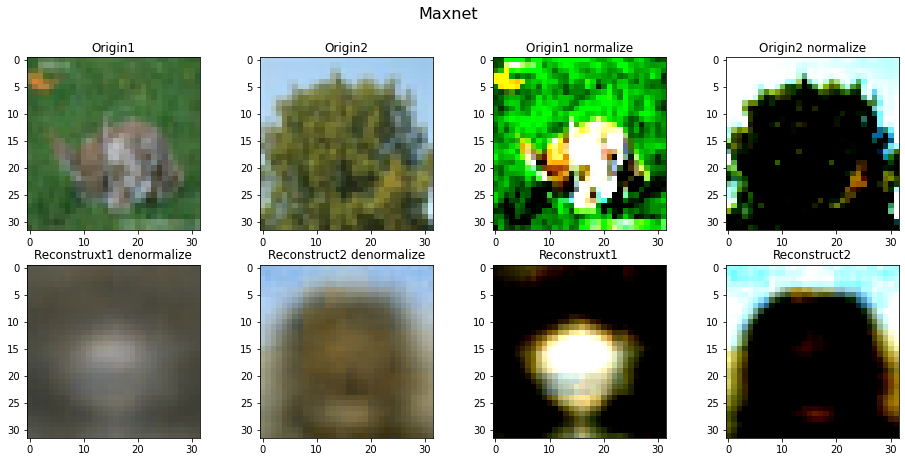

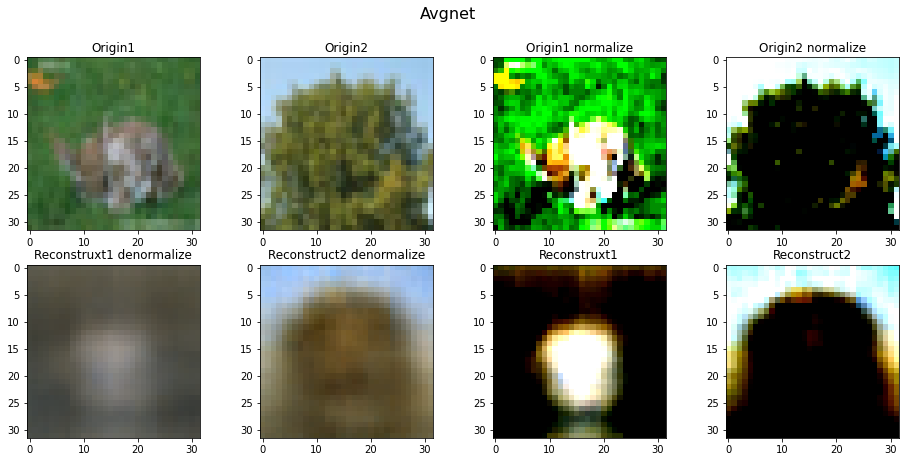

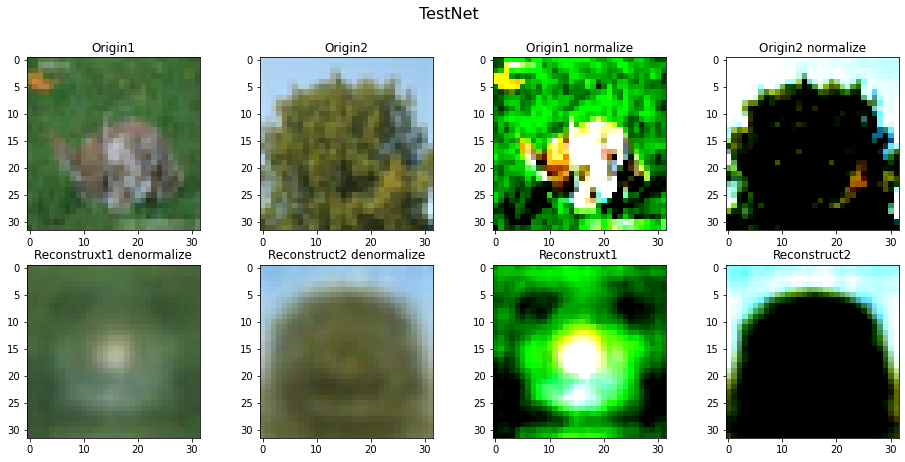

In [ ]:
DATA_PATH = 'trainX.npy'
data = np.load(DATA_PATH)
two_imgs = data[0:2]
max_l1, max_l2 = report(two_imgs, "model_max.pth", Maxnet(latent_dim=32))
avg_l1, avg_l2 = report(two_imgs, "model_avg.pth", Avgnet(latent_dim=32))
test_l1, test_l2 = report(two_imgs, "model_de.pth", TestNet(latent_dim=32))

In [ ]:
print(f"max_l1: {max_l1}, max_l2: {max_l2}, \navg_l1: {avg_l1}, avg_l2: {avg_l2}, \nde_l1: {test_l1}, de_l2: {test_l2}")

max_l1: 0.008792463418445485, max_l2: 0.009538935145274109, 
avg_l1: 0.009263240204625926, avg_l2: 0.009753611378653543, 
de_l1: 0.00545969776114701, de_l2: 0.008640171999860863


## Visualize_X.npy

In [ ]:
def k_latent(model, device, loader, n_iter, reduced_method, reduced_dim, perplexity):
    assert reduced_method in ['pca', 'tsne', None]
    
    model.eval()
    latent_vec = torch.tensor([]).to(device, dtype=torch.float)
    for idx, (image_aug, image) in enumerate(loader):
        print("predict %d / %d" % (idx, len(loader)) , end='\r')
        image = image.to(device, dtype=torch.float)
        latent, r = model(image)
        latent_vec = torch.cat((latent_vec, latent), dim=0)

    latent_vec = latent_vec.cpu().detach().numpy()
    
    if reduced_method == 'tsne':
        tsne = TSNE(n_components=reduced_dim, verbose=1, method='exact', perplexity=perplexity, n_iter=n_iter)
        latent_vec = tsne.fit_transform(latent_vec)
    elif reduced_method == 'pca':
        pca = PCA(n_components=reduced_dim, copy=False, whiten=True, svd_solver='full')
        latent_vec = pca.fit_transform(latent_vec)
    return latent_vec
  
def visualize(DATA_PATH, MODEL_NAME, MODEL_STRUC, REDUCED_DIM, NUM_ITER):
  dataset = Dataset(DATA_PATH)
  loader = data.DataLoader(dataset, batch_size=64, shuffle=False)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = MODEL_STRUC.to(device)
  model.load_state_dict(torch.load(MODEL_NAME))
  model.eval()

  predicted_pca = k_latent(model, device, loader, NUM_ITER, reduced_method="pca", reduced_dim=REDUCED_DIM, perplexity=15)
  predicted_tsne = k_latent(model, device, loader, NUM_ITER, reduced_method="tsne", reduced_dim=REDUCED_DIM, perplexity=15)
  return predicted_pca, predicted_tsne

In [ ]:
def pca_tsne_plot(pca, tsne):
  fig = plt.figure(figsize=(12, 5))

  ax1 = fig.add_subplot(1, 2, 1)
  plt.scatter(pca[:2500, 0], pca[:2500, 1], s=0.8)
  plt.scatter(pca[2500:, 0], pca[2500:, 1], s=0.8)
  ax2 = fig.add_subplot(1, 2, 2)
  plt.scatter(tsne[:2500, 0], tsne[:2500, 1], s=0.8)
  plt.scatter(tsne[2500:, 0], tsne[2500:, 1], s=0.8)

  ax1.title.set_text("pca")
  ax2.title.set_text("tsne")
  return

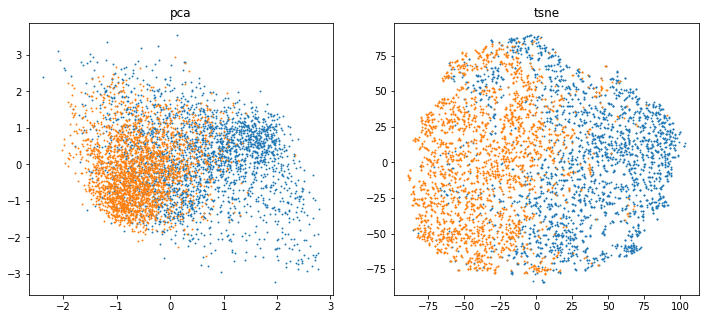

In [ ]:
DATA_PATH = 'visualization_X.npy'
MODEL_NAME = 'model_max.pth'
REDUCED_DIM = 2
NUM_ITER = 1000

max_pca, max_tsne = visualize(DATA_PATH, MODEL_NAME, Maxnet(latent_dim=32), REDUCED_DIM, NUM_ITER)
pca_tsne_plot(max_pca, max_tsne)